In [3]:
# ================================
# CELL 1: Environment Setup
# ================================

from google.colab import drive
drive.mount('/content/drive')

# Basic libraries
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from sklearn.model_selection import train_test_split
import shutil

print(" Environment setup completed")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 Environment setup completed


In [4]:
# ================================
# CELL 2: Dataset Path Setup & Verification
# ================================

# Base project path (KEEP THIS CONSISTENT)
BASE_PATH = "/content/drive/My Drive/kaggle/input/Road_Surface_Anomaly_Detection_using_AI-Driven_CPS"

IMAGES_PATH = os.path.join(BASE_PATH, "images")
ANNOTATIONS_PATH = os.path.join(BASE_PATH, "annotations")

print(" Verifying dataset paths...")
print("Base Path:", BASE_PATH)
print("Images Path:", IMAGES_PATH)
print("Annotations Path:", ANNOTATIONS_PATH)

# Check existence
if not os.path.exists(IMAGES_PATH):
    raise FileNotFoundError(" Images folder not found!")

if not os.path.exists(ANNOTATIONS_PATH):
    raise FileNotFoundError(" Annotations folder not found!")

image_files = sorted(os.listdir(IMAGES_PATH))
annotation_files = sorted(os.listdir(ANNOTATIONS_PATH))

print(f" Found {len(image_files)} images")
print(f" Found {len(annotation_files)} annotation files")

# Show sample files
print("\n Sample image files:")
for f in image_files[:5]:
    print(" -", f)

print("\n Sample annotation files:")
for f in annotation_files[:5]:
    print(" -", f)


 Verifying dataset paths...
Base Path: /content/drive/My Drive/kaggle/input/Road_Surface_Anomaly_Detection_using_AI-Driven_CPS
Images Path: /content/drive/My Drive/kaggle/input/Road_Surface_Anomaly_Detection_using_AI-Driven_CPS/images
Annotations Path: /content/drive/My Drive/kaggle/input/Road_Surface_Anomaly_Detection_using_AI-Driven_CPS/annotations
 Found 665 images
 Found 665 annotation files

 Sample image files:
 - potholes0.png
 - potholes1.png
 - potholes10.png
 - potholes100.png
 - potholes101.png

 Sample annotation files:
 - potholes0.xml
 - potholes1.xml
 - potholes10.xml
 - potholes100.xml
 - potholes101.xml


In [5]:
# ================================
# CELL 3: XML Annotation Parsing
# ================================

def parse_annotation(xml_path):
    """
    Parses a single PASCAL VOC XML file
    Returns image size and list of objects with bounding boxes
    """
    tree = ET.parse(xml_path)
    root = tree.getroot()

    size = root.find("size")
    width = int(size.find("width").text)
    height = int(size.find("height").text)

    objects = []
    for obj in root.findall("object"):
        class_name = obj.find("name").text.lower()

        bndbox = obj.find("bndbox")
        xmin = int(float(bndbox.find("xmin").text))
        ymin = int(float(bndbox.find("ymin").text))
        xmax = int(float(bndbox.find("xmax").text))
        ymax = int(float(bndbox.find("ymax").text))

        objects.append({
            "class": class_name,
            "bbox": [xmin, ymin, xmax, ymax]
        })

    return {
        "width": width,
        "height": height,
        "objects": objects
    }


# Test parsing on one sample annotation
sample_xml = os.path.join(ANNOTATIONS_PATH, annotation_files[0])
sample_data = parse_annotation(sample_xml)

print(" Sample Annotation Parsed Successfully")
print("Image size:", sample_data["width"], "x", sample_data["height"])
print("Objects found:", len(sample_data["objects"]))

for obj in sample_data["objects"]:
    print(" -", obj)


 Sample Annotation Parsed Successfully
Image size: 450 x 300
Objects found: 12
 - {'class': 'pothole', 'bbox': [141, 233, 203, 262]}
 - {'class': 'pothole', 'bbox': [201, 219, 238, 236]}
 - {'class': 'pothole', 'bbox': [87, 172, 147, 196]}
 - {'class': 'pothole', 'bbox': [181, 171, 212, 185]}
 - {'class': 'pothole', 'bbox': [236, 175, 272, 185]}
 - {'class': 'pothole', 'bbox': [301, 173, 323, 183]}
 - {'class': 'pothole', 'bbox': [231, 169, 284, 177]}
 - {'class': 'pothole', 'bbox': [175, 142, 213, 156]}
 - {'class': 'pothole', 'bbox': [78, 141, 94, 148]}
 - {'class': 'pothole', 'bbox': [123, 145, 152, 157]}
 - {'class': 'pothole', 'bbox': [154, 130, 168, 137]}
 - {'class': 'pothole', 'bbox': [320, 216, 408, 246]}


In [6]:
# ================================
# CELL 4: Class Distribution Analysis
# ================================

from collections import Counter

class_counter = Counter()
total_objects = 0

for xml_file in annotation_files:
    xml_path = os.path.join(ANNOTATIONS_PATH, xml_file)
    data = parse_annotation(xml_path)

    for obj in data["objects"]:
        class_counter[obj["class"]] += 1
        total_objects += 1

print(" Class Distribution in Dataset")
print("--------------------------------")
for cls, count in class_counter.items():
    print(f"{cls}: {count}")

print("--------------------------------")
print(f"Total annotated objects: {total_objects}")
print(f"Total images: {len(image_files)}")
print(f"Average objects per image: {total_objects / len(image_files):.2f}")


 Class Distribution in Dataset
--------------------------------
pothole: 1740
--------------------------------
Total annotated objects: 1740
Total images: 665
Average objects per image: 2.62


In [7]:
# ================================
# CELL 5: Create YOLO Dataset Structure
# ================================

YOLO_BASE = os.path.join(BASE_PATH, "yolo_dataset")

folders = [
    "images/train",
    "images/val",
    "images/test",
    "labels/train",
    "labels/val",
    "labels/test"
]

for folder in folders:
    os.makedirs(os.path.join(YOLO_BASE, folder), exist_ok=True)

print(" YOLO dataset folder structure created at:")
print(YOLO_BASE)


 YOLO dataset folder structure created at:
/content/drive/My Drive/kaggle/input/Road_Surface_Anomaly_Detection_using_AI-Driven_CPS/yolo_dataset


In [8]:
# ================================
# CELL 6: Convert VOC XML to YOLO Format
# ================================

# Class mapping (single class as per dataset)
CLASS_MAPPING = {"pothole": 0}

def convert_voc_to_yolo(xml_path, txt_output_path):
    data = parse_annotation(xml_path)

    img_w = data["width"]
    img_h = data["height"]

    yolo_lines = []

    for obj in data["objects"]:
        class_name = obj["class"]
        if class_name not in CLASS_MAPPING:
            continue

        class_id = CLASS_MAPPING[class_name]
        xmin, ymin, xmax, ymax = obj["bbox"]

        # YOLO normalized format
        x_center = ((xmin + xmax) / 2) / img_w
        y_center = ((ymin + ymax) / 2) / img_h
        width = (xmax - xmin) / img_w
        height = (ymax - ymin) / img_h

        yolo_lines.append(
            f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}"
        )

    with open(txt_output_path, "w") as f:
        f.write("\n".join(yolo_lines))


print(" VOC → YOLO conversion function ready")


 VOC → YOLO conversion function ready


In [9]:
# ================================
# CELL 7: Dataset Split & File Copy
# ================================

# Pair images with annotations
pairs = []

for img in image_files:
    base = os.path.splitext(img)[0]
    xml = base + ".xml"
    if xml in annotation_files:
        pairs.append((img, xml))

print(f" Valid image-annotation pairs: {len(pairs)}")

# Train / Val / Test split
train_pairs, temp_pairs = train_test_split(
    pairs, test_size=0.30, random_state=42
)

val_pairs, test_pairs = train_test_split(
    temp_pairs, test_size=0.33, random_state=42
)

print(f" Split Summary")
print(f"Train: {len(train_pairs)}")
print(f"Val  : {len(val_pairs)}")
print(f"Test : {len(test_pairs)}")


def copy_split(pairs, split):
    img_dst = os.path.join(YOLO_BASE, "images", split)
    lbl_dst = os.path.join(YOLO_BASE, "labels", split)

    count = 0
    for img, xml in pairs:
        # Copy image
        shutil.copy(
            os.path.join(IMAGES_PATH, img),
            os.path.join(img_dst, img)
        )

        # Convert & save annotation
        txt_name = os.path.splitext(img)[0] + ".txt"
        convert_voc_to_yolo(
            os.path.join(ANNOTATIONS_PATH, xml),
            os.path.join(lbl_dst, txt_name)
        )
        count += 1

    return count


train_count = copy_split(train_pairs, "train")
val_count = copy_split(val_pairs, "val")
test_count = copy_split(test_pairs, "test")

print("\n Files copied successfully")
print(f"Train: {train_count}")
print(f"Val  : {val_count}")
print(f"Test : {test_count}")


 Valid image-annotation pairs: 665
 Split Summary
Train: 465
Val  : 134
Test : 66

 Files copied successfully
Train: 465
Val  : 134
Test : 66


In [10]:
# ================================
# CELL 8: Create dataset.yaml
# ================================

DATASET_YAML_PATH = os.path.join(YOLO_BASE, "dataset.yaml")

yaml_content = f"""
path: {YOLO_BASE}

train: images/train
val: images/val
test: images/test

nc: 1
names: ['pothole']
"""

with open(DATASET_YAML_PATH, "w") as f:
    f.write(yaml_content)

print(" dataset.yaml created successfully")
print("\n dataset.yaml content:\n")
print(yaml_content)

 dataset.yaml created successfully

 dataset.yaml content:


path: /content/drive/My Drive/kaggle/input/Road_Surface_Anomaly_Detection_using_AI-Driven_CPS/yolo_dataset

train: images/train
val: images/val
test: images/test

nc: 1
names: ['pothole']



In [11]:
# ================================
# CELL 9: Install YOLO & Verify Environment
# ================================

# Install required packages
!pip install -q ultralytics torch torchvision opencv-python matplotlib

# Verify PyTorch and device
import torch
from ultralytics import YOLO

print("🔧 Environment Verification")
print("----------------------------")
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))
else:
    print(" Training will run on CPU (slower but acceptable)")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 52.1 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
🔧 Environment Verification
----------------------------
PyTorch version: 2.9.0+cu126
CUDA available: True
GPU: Tesla T4


In [12]:
# ================================
# CELL 10: YOLOv8 Model Training
# ================================

# Load YOLOv8 nano model (lightweight & suitable for low-cost CPS)
model = YOLO("yolov8n.pt")

print(" Starting YOLOv8 Training...")

results = model.train(
    data=DATASET_YAML_PATH,
    epochs=50,          # sufficient for hackathon-level results
    imgsz=640,
    batch=16,
    device=0,           # use GPU
    project=BASE_PATH,
    name="yolov8_pothole_detection",
    patience=10,
    verbose=True
)

print(" Training completed successfully")

 Starting YOLOv8 Training...
Ultralytics 8.3.240 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/My Drive/kaggle/input/Road_Surface_Anomaly_Detection_using_AI-Driven_CPS/yolo_dataset/dataset.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8_pothole_detection, n

In [13]:
# ================================
# CELL 11: Model Evaluation (Authentic Metrics)
# ================================

from ultralytics import YOLO

# Path to best model (generated automatically by training)
BEST_MODEL_PATH = os.path.join(
    BASE_PATH,
    "yolov8_pothole_detection",
    "weights",
    "best.pt"
)

print("📦 Loading trained model from:")
print(BEST_MODEL_PATH)

model = YOLO(BEST_MODEL_PATH)

# Run evaluation on test set
metrics = model.val(
    data=DATASET_YAML_PATH,
    split="test"
)

print("\n===== FINAL MODEL PERFORMANCE =====")
print(f"Precision     : {metrics.results_dict['metrics/precision(B)']:.4f}")
print(f"Recall        : {metrics.results_dict['metrics/recall(B)']:.4f}")
print(f"mAP@0.5       : {metrics.results_dict['metrics/mAP50(B)']:.4f}")
print(f"mAP@0.5:0.95  : {metrics.results_dict['metrics/mAP50-95(B)']:.4f}")


📦 Loading trained model from:
/content/drive/My Drive/kaggle/input/Road_Surface_Anomaly_Detection_using_AI-Driven_CPS/yolov8_pothole_detection/weights/best.pt
Ultralytics 8.3.240 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.5±0.1 ms, read: 126.6±86.1 MB/s, size: 349.9 KB)
val: Scanning /content/drive/My Drive/kaggle/input/Road_Surface_Anomaly_Detection_using_AI-Driven_CPS/yolo_dataset/labels/test... 66 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 66/66 140.0it/s 0.5s
val: New cache created: /content/drive/My Drive/kaggle/input/Road_Surface_Anomaly_Detection_using_AI-Driven_CPS/yolo_dataset/labels/test.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 5/5 1.1it/s 4.5s
                   all         66        197      0.724      0.718      0.784      0.481
Speed: 7.7ms preprocess, 24.6ms 

In [15]:
from ultralytics import YOLO
import os

# Load trained YOLOv8-n model
model = YOLO(
    "/content/drive/My Drive/kaggle/input/"
    "Road_Surface_Anomaly_Detection_using_AI-Driven_CPS/"
    "yolov8_pothole_detection/weights/best.pt"
)

# Path to test images
test_images_path = (
    "/content/drive/My Drive/kaggle/input/"
    "Road_Surface_Anomaly_Detection_using_AI-Driven_CPS/"
    "yolo_dataset/images/test"
)

# Run inference
results = model.predict(
    source=test_images_path,
    imgsz=640,
    conf=0.25,
    save=True
)

print("Inference completed. Results saved.")



image 1/66 /content/drive/My Drive/kaggle/input/Road_Surface_Anomaly_Detection_using_AI-Driven_CPS/yolo_dataset/images/test/potholes107.png: 384x640 2 potholes, 60.9ms
image 2/66 /content/drive/My Drive/kaggle/input/Road_Surface_Anomaly_Detection_using_AI-Driven_CPS/yolo_dataset/images/test/potholes124.png: 480x640 2 potholes, 57.7ms
image 3/66 /content/drive/My Drive/kaggle/input/Road_Surface_Anomaly_Detection_using_AI-Driven_CPS/yolo_dataset/images/test/potholes136.png: 640x640 4 potholes, 9.3ms
image 4/66 /content/drive/My Drive/kaggle/input/Road_Surface_Anomaly_Detection_using_AI-Driven_CPS/yolo_dataset/images/test/potholes147.png: 448x640 1 pothole, 55.9ms
image 5/66 /content/drive/My Drive/kaggle/input/Road_Surface_Anomaly_Detection_using_AI-Driven_CPS/yolo_dataset/images/test/potholes152.png: 640x640 3 potholes, 8.1ms
image 6/66 /content/drive/My Drive/kaggle/input/Road_Surface_Anomaly_Detection_using_AI-Driven_CPS/yolo_dataset/images/test/potholes153.png: 640x480 1 pothole, 85

In [16]:
from ultralytics import YOLO
import os

# Load trained model
model = YOLO(
    "/content/drive/My Drive/kaggle/input/"
    "Road_Surface_Anomaly_Detection_using_AI-Driven_CPS/"
    "yolov8_pothole_detection/weights/best.pt"
)

test_images_path = (
    "/content/drive/My Drive/kaggle/input/"
    "Road_Surface_Anomaly_Detection_using_AI-Driven_CPS/"
    "yolo_dataset/images/test"
)

# CPS thresholds
CONF_THRESHOLD = 0.5
POTHOLE_COUNT_THRESHOLD = 3

road_reports = []

results = model.predict(source=test_images_path, conf=0.25)

for r in results:
    detections = r.boxes
    high_conf_detections = [
        box for box in detections if box.conf.item() >= CONF_THRESHOLD
    ]

    pothole_count = len(high_conf_detections)

    if pothole_count >= POTHOLE_COUNT_THRESHOLD:
        condition = "DAMAGED ROAD"
    else:
        condition = "NORMAL ROAD"

    road_reports.append({
        "image": os.path.basename(r.path),
        "potholes_detected": pothole_count,
        "road_condition": condition
    })

# Display sample CPS outputs
for report in road_reports[:5]:
    print(report)



image 1/66 /content/drive/My Drive/kaggle/input/Road_Surface_Anomaly_Detection_using_AI-Driven_CPS/yolo_dataset/images/test/potholes107.png: 384x640 2 potholes, 7.2ms
image 2/66 /content/drive/My Drive/kaggle/input/Road_Surface_Anomaly_Detection_using_AI-Driven_CPS/yolo_dataset/images/test/potholes124.png: 480x640 2 potholes, 6.9ms
image 3/66 /content/drive/My Drive/kaggle/input/Road_Surface_Anomaly_Detection_using_AI-Driven_CPS/yolo_dataset/images/test/potholes136.png: 640x640 4 potholes, 8.3ms
image 4/66 /content/drive/My Drive/kaggle/input/Road_Surface_Anomaly_Detection_using_AI-Driven_CPS/yolo_dataset/images/test/potholes147.png: 448x640 1 pothole, 6.8ms
image 5/66 /content/drive/My Drive/kaggle/input/Road_Surface_Anomaly_Detection_using_AI-Driven_CPS/yolo_dataset/images/test/potholes152.png: 640x640 3 potholes, 8.4ms
image 6/66 /content/drive/My Drive/kaggle/input/Road_Surface_Anomaly_Detection_using_AI-Driven_CPS/yolo_dataset/images/test/potholes153.png: 640x480 1 pothole, 6.9ms

In [17]:
import random
import pandas as pd

# Simulated GPS region (example: Kolkata area)
LAT_RANGE = (22.50, 22.65)
LON_RANGE = (88.30, 88.45)

geo_reports = []

for report in road_reports:
    geo_reports.append({
        "image": report["image"],
        "potholes_detected": report["potholes_detected"],
        "road_condition": report["road_condition"],
        "latitude": round(random.uniform(*LAT_RANGE), 6),
        "longitude": round(random.uniform(*LON_RANGE), 6)
    })

df_geo = pd.DataFrame(geo_reports)
df_geo.head()


,image,potholes_detected,road_condition,latitude,longitude
0,potholes107.png,1,NORMAL ROAD,22.637735,88.424478
1,potholes124.png,1,NORMAL ROAD,22.645170,88.353707
2,potholes136.png,4,DAMAGED ROAD,22.633749,88.332766
3,potholes147.png,1,NORMAL ROAD,22.520891,88.320962
4,potholes152.png,3,DAMAGED ROAD,22.514225,88.419910


In [20]:
import folium

# Center map at average location
center_lat = df_geo["latitude"].mean()
center_lon = df_geo["longitude"].mean()

road_map = folium.Map(location=[center_lat, center_lon], zoom_start=12)

for _, row in df_geo.iterrows():
    if row["road_condition"] == "DAMAGED ROAD":
        color = "red"
        icon = "warning-sign"
    else:
        color = "green"
        icon = "ok-sign"

    popup_text = (
        f"Image: {row['image']}<br>"
        f"Potholes Detected: {row['potholes_detected']}<br>"
        f"Condition: {row['road_condition']}"
    )

    folium.Marker(
        location=[row["latitude"], row["longitude"]],
        popup=popup_text,
        icon=folium.Icon(color=color, icon=icon)
    ).add_to(road_map)

road_map



image 1/1 /content/drive/My Drive/kaggle/input/Road_Surface_Anomaly_Detection_using_AI-Driven_CPS/yolo_dataset/images/test/potholes87.png: 384x640 2 potholes, 9.2ms
Speed: 2.4ms preprocess, 9.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


(np.float64(-0.5), np.float64(532.5), np.float64(299.5), np.float64(-0.5))

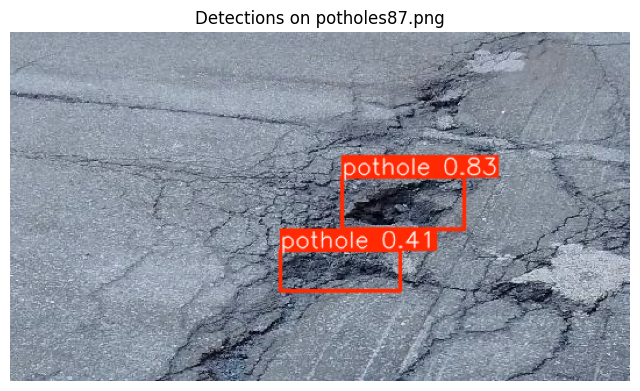

In [21]:
import random
from ultralytics import YOLO
import matplotlib.pyplot as plt
import cv2

model = YOLO(
    "/content/drive/My Drive/kaggle/input/"
    "Road_Surface_Anomaly_Detection_using_AI-Driven_CPS/"
    "yolov8_pothole_detection/weights/best.pt"
)

test_img_dir = (
    "/content/drive/My Drive/kaggle/input/"
    "Road_Surface_Anomaly_Detection_using_AI-Driven_CPS/"
    "yolo_dataset/images/test"
)

# Pick a random image
img_name = random.choice(os.listdir(test_img_dir))
img_path = os.path.join(test_img_dir, img_name)

# Run inference
results = model.predict(img_path, conf=0.25)

# Show result
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(8,5))
plt.imshow(results[0].plot())
plt.title(f"Detections on {img_name}")
plt.axis("off")

In [22]:
import os
import cv2
import torch
import pandas as pd
import numpy as np
from ultralytics import YOLO


In [23]:
MODEL_PATH = "/content/drive/My Drive/kaggle/input/Road_Surface_Anomaly_Detection_using_AI-Driven_CPS/yolov8_pothole_detection/weights/best.pt"

model = YOLO(MODEL_PATH)
print(" Model loaded successfully")

 Model loaded successfully


In [24]:
def cps_severity_decision(pothole_count):
    if pothole_count == 0:
        return "NORMAL ROAD", "LOW", 0
    elif pothole_count <= 2:
        return "SLIGHTLY DAMAGED", "LOW", 30
    elif pothole_count <= 5:
        return "DAMAGED ROAD", "MEDIUM", 60
    else:
        return "SEVERELY DAMAGED", "HIGH", 90

In [25]:
IMAGE_PATH = "/content/drive/My Drive/kaggle/input/Road_Surface_Anomaly_Detection_using_AI-Driven_CPS/yolo_dataset/images/test/potholes87.png"

results = model(IMAGE_PATH, conf=0.25)


image 1/1 /content/drive/My Drive/kaggle/input/Road_Surface_Anomaly_Detection_using_AI-Driven_CPS/yolo_dataset/images/test/potholes87.png: 384x640 2 potholes, 7.3ms
Speed: 2.3ms preprocess, 7.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


In [26]:
boxes = results[0].boxes

pothole_count = len(boxes)

confidences = boxes.conf.cpu().numpy() if pothole_count > 0 else []
avg_conf = np.mean(confidences) if pothole_count > 0 else 0

In [27]:
road_condition, severity_level, severity_score = cps_severity_decision(pothole_count)

print(" CPS DECISION OUTPUT")
print("---------------------")
print("Potholes Detected :", pothole_count)
print("Road Condition    :", road_condition)
print("Severity Level    :", severity_level)
print("Severity Score    :", severity_score)
print("Avg Confidence    :", round(avg_conf, 3))

 CPS DECISION OUTPUT
---------------------
Potholes Detected : 2
Road Condition    : SLIGHTLY DAMAGED
Severity Level    : LOW
Severity Score    : 30
Avg Confidence    : 0.62


In [28]:
latitude = 22.637735
longitude = 88.424478

In [29]:
final_output = pd.DataFrame([{
    "image": os.path.basename(IMAGE_PATH),
    "potholes_detected": pothole_count,
    "avg_confidence": round(avg_conf, 3),
    "road_condition": road_condition,
    "severity_level": severity_level,
    "severity_score": severity_score,
    "latitude": latitude,
    "longitude": longitude
}])

final_output

,image,potholes_detected,avg_confidence,road_condition,severity_level,severity_score,latitude,longitude
0,potholes87.png,2,0.62,SLIGHTLY DAMAGED,LOW,30,22.637735,88.424478


In [30]:
final_output.to_csv("road_anomaly_cps_output.csv", index=False)
print(" CPS output saved successfully")

 CPS output saved successfully


In [31]:
!pip install folium

In [32]:
import folium

In [33]:
df = pd.read_csv("road_anomaly_cps_output.csv")
df

,image,potholes_detected,avg_confidence,road_condition,severity_level,severity_score,latitude,longitude
0,potholes87.png,2,0.62,SLIGHTLY DAMAGED,LOW,30,22.637735,88.424478


In [34]:
def severity_color(severity_level):
    if severity_level == "LOW":
        return "green"
    elif severity_level == "MEDIUM":
        return "orange"
    else:
        return "red"

In [37]:
# Initialize map centered at first location
m = folium.Map(
    location=[df.latitude.mean(), df.longitude.mean()],
    zoom_start=13
)

# Add markers
for _, row in df.iterrows():
    folium.CircleMarker(
        location=[row["latitude"], row["longitude"]],
        radius=8,
        color=severity_color(row["severity_level"]),
        fill=True,
        fill_opacity=0.8,
        popup=f"""
        <b>Image:</b> {row['image']}<br>
        <b>Potholes:</b> {row['potholes_detected']}<br>
        <b>Condition:</b> {row['road_condition']}<br>
        <b>Severity:</b> {row['severity_level']}<br>
        <b>Score:</b> {row['severity_score']}<br>
        <b>Confidence:</b> {row['avg_confidence']}
        """
    ).add_to(m)

m

In [38]:
df["severity_level"].value_counts()

,count
severity_level,
LOW,1


In [39]:
def cps_decision(potholes, avg_conf):
    if potholes == 0:
        return "NORMAL ROAD", "NONE", 0
    elif potholes <= 2:
        return "SLIGHTLY DAMAGED", "LOW", 30
    elif potholes <= 5:
        return "DAMAGED ROAD", "MEDIUM", 60
    else:
        return "SEVERELY DAMAGED", "HIGH", 90

In [41]:
import os

TEST_IMAGE_DIR = "/content/drive/My Drive/kaggle/input/Road_Surface_Anomaly_Detection_using_AI-Driven_CPS/yolo_dataset/images/test"

test_images = [
    os.path.join(TEST_IMAGE_DIR, img)
    for img in os.listdir(TEST_IMAGE_DIR)
    if img.endswith((".jpg", ".png", ".jpeg"))
]

print(f"Total test images found: {len(test_images)}")
print(test_images[:5])  # preview


Total test images found: 66
['/content/drive/My Drive/kaggle/input/Road_Surface_Anomaly_Detection_using_AI-Driven_CPS/yolo_dataset/images/test/potholes566.png', '/content/drive/My Drive/kaggle/input/Road_Surface_Anomaly_Detection_using_AI-Driven_CPS/yolo_dataset/images/test/potholes155.png', '/content/drive/My Drive/kaggle/input/Road_Surface_Anomaly_Detection_using_AI-Driven_CPS/yolo_dataset/images/test/potholes629.png', '/content/drive/My Drive/kaggle/input/Road_Surface_Anomaly_Detection_using_AI-Driven_CPS/yolo_dataset/images/test/potholes332.png', '/content/drive/My Drive/kaggle/input/Road_Surface_Anomaly_Detection_using_AI-Driven_CPS/yolo_dataset/images/test/potholes609.png']


In [42]:
from ultralytics import YOLO
import numpy as np

model = YOLO("/content/drive/My Drive/kaggle/input/Road_Surface_Anomaly_Detection_using_AI-Driven_CPS/yolov8_pothole_detection/weights/best.pt")

def run_detection(image_path):
    results = model(image_path, conf=0.25, imgsz=640, verbose=False)
    boxes = results[0].boxes

    if boxes is None:
        return 0, 0.0

    potholes = len(boxes)
    avg_conf = float(np.mean(boxes.conf.cpu().numpy()))

    return potholes, round(avg_conf, 2)

In [43]:
def cps_decision(potholes, avg_conf):
    if potholes == 0:
        return "NORMAL ROAD", "NONE", 0
    elif potholes <= 2:
        return "SLIGHTLY DAMAGED", "LOW", 30
    elif potholes <= 5:
        return "DAMAGED ROAD", "MEDIUM", 60
    else:
        return "SEVERELY DAMAGED", "HIGH", 90

In [46]:
import random

results = []

for img in test_images[:10]:   # now this works
    potholes, avg_conf = run_detection(img)
    road_cond, severity, score = cps_decision(potholes, avg_conf)

    results.append({
        "image": os.path.basename(img),
        "potholes_detected": potholes,
        "avg_confidence": avg_conf,
        "road_condition": road_cond,
        "severity_level": severity,
        "severity_score": score,
        "latitude": 22.5 + random.random() * 0.2,
        "longitude": 88.3 + random.random() * 0.2
    })

df = pd.DataFrame(results)
df


,image,potholes_detected,avg_confidence,road_condition,severity_level,severity_score,latitude,longitude
0,potholes566.png,3,0.72,DAMAGED ROAD,MEDIUM,60,22.570059,88.336064
1,potholes155.png,1,0.87,SLIGHTLY DAMAGED,LOW,30,22.600727,88.307876
2,potholes629.png,8,0.63,SEVERELY DAMAGED,HIGH,90,22.520184,88.497647
3,potholes332.png,6,0.51,SEVERELY DAMAGED,HIGH,90,22.539871,88.371711
4,potholes609.png,3,0.57,DAMAGED ROAD,MEDIUM,60,22.646320,88.467665
5,potholes217.png,4,0.75,DAMAGED ROAD,MEDIUM,60,22.683696,88.333885
6,potholes218.png,2,0.60,SLIGHTLY DAMAGED,LOW,30,22.634528,88.493310
7,potholes535.png,6,0.59,SEVERELY DAMAGED,HIGH,90,22.511610,88.435240
8,potholes224.png,1,0.92,SLIGHTLY DAMAGED,LOW,30,22.669085,88.368463
9,potholes5.png,3,0.63,DAMAGED ROAD,MEDIUM,60,22.550137,88.419358


In [47]:
df["severity_level"].value_counts()

,count
severity_level,
MEDIUM,4
LOW,3
HIGH,3


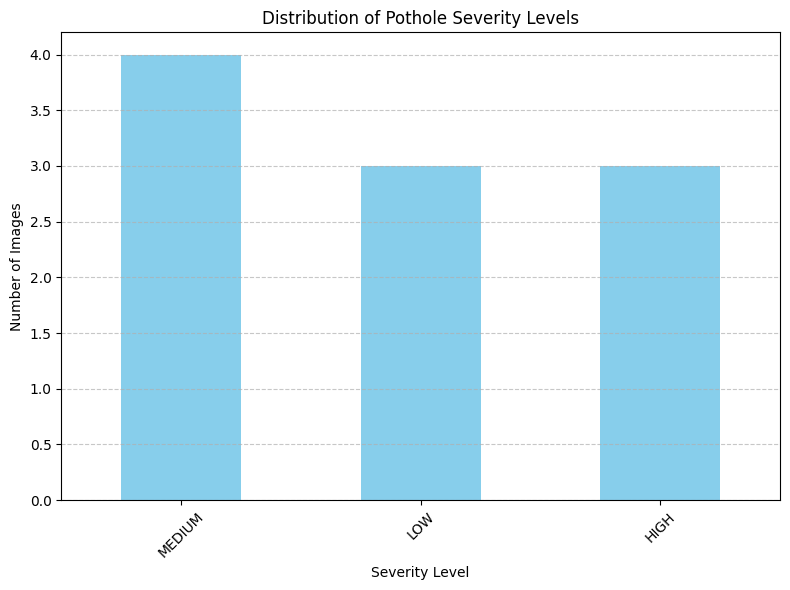

In [49]:
test_images = [os.path.join(test_img_dir, f) for f in os.listdir(test_img_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

def run_detection(image_path):
    results = model(image_path, conf=0.25)
    boxes = results[0].boxes
    if boxes is None or len(boxes) == 0:
        return 0, 0.0
    pothole_count = len(boxes)
    confidences = boxes.conf.cpu().numpy()
    avg_conf = np.mean(confidences)
    return pothole_count, avg_conf

def random_lat():
    return random.uniform(*LAT_RANGE)

def random_lon():
    return random.uniform(*LON_RANGE)

results = []

for img in test_images[:10]:   # take 10 images
    potholes, avg_conf = run_detection(img)
    road_cond, severity, score = cps_decision(potholes, avg_conf)

    results.append({
        "image": os.path.basename(img),
        "potholes_detected": potholes,
        "avg_confidence": round(avg_conf, 3),
        "road_condition": road_cond,
        "severity_level": severity,
        "severity_score": score,
        "latitude": round(random_lat(), 6),
        "longitude": round(random_lon(), 6)
    })

df = pd.DataFrame(results)
df

# Visualize the distribution of severity levels
plt.figure(figsize=(8, 6))
df['severity_level'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Distribution of Pothole Severity Levels')
plt.xlabel('Severity Level')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [50]:
# Initialize map centered at first location
m = folium.Map(
    location=[df.latitude.mean(), df.longitude.mean()],
    zoom_start=13
)

# Add markers
for _, row in df.iterrows():
    folium.CircleMarker(
        location=[row["latitude"], row["longitude"]],
        radius=8,
        color=severity_color(row["severity_level"]),
        fill=True,
        fill_opacity=0.8,
        popup=f"""
        <b>Image:</b> {row['image']}<br>
        <b>Potholes:</b> {row['potholes_detected']}<br>
        <b>Condition:</b> {row['road_condition']}<br>
        <b>Severity:</b> {row['severity_level']}<br>
        <b>Score:</b> {row['severity_score']}<br>
        <b>Confidence:</b> {row['avg_confidence']}
        """
    ).add_to(m)

m
